In [27]:
# 0. Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.modeling import (
    DoseResponseGP,
    estimate_replicate_noise,
    estimate_plate_drift_from_controls,
    apply_plate_drift_correction,
)

plt.style.use("seaborn-v0_8")


In [28]:
# 1. Load data
df = pd.read_csv("data/raw/phase0_all_plates.csv")
df.head()


,plate_id,well_id,cell_line,compound,dose_uM,time_h,raw_signal,is_control,date,incubator_id,liquid_handler_id,viability_norm
0,HepG2_P1,A09,HepG2,DMSO,0.0,24,9632.366487,1,2025-11-01,inc1,manual,0.951220
1,HepG2_P1,A10,HepG2,DMSO,0.0,24,10527.584138,1,2025-11-01,inc1,manual,1.039625
2,HepG2_P1,A11,HepG2,DMSO,0.0,24,10622.640898,1,2025-11-01,inc1,manual,1.049012
3,HepG2_P1,A12,HepG2,DMSO,0.0,24,9176.840946,1,2025-11-01,inc1,manual,0.906236
4,HepG2_P1,B09,HepG2,DMSO,0.0,24,9501.268786,1,2025-11-01,inc1,manual,0.938274


In [29]:
# 2. Drift correction
drift_df = estimate_plate_drift_from_controls(
    df,
    plate_col="plate_id",
    viability_col="viability_norm",
    is_control_col="is_control"
)

df_corr = apply_plate_drift_correction(
    df,
    drift_df,
    plate_col="plate_id",
    viability_col="viability_norm",
    corrected_col="viability_corrected"
)

df_corr.head()


,plate_id,well_id,cell_line,compound,dose_uM,time_h,raw_signal,is_control,date,incubator_id,liquid_handler_id,viability_norm,control_delta,viability_corrected
0,HepG2_P1,A09,HepG2,DMSO,0.0,24,9632.366487,1,2025-11-01,inc1,manual,0.951220,0.0,0.951220
1,HepG2_P1,A10,HepG2,DMSO,0.0,24,10527.584138,1,2025-11-01,inc1,manual,1.039625,0.0,1.039625
2,HepG2_P1,A11,HepG2,DMSO,0.0,24,10622.640898,1,2025-11-01,inc1,manual,1.049012,0.0,1.049012
3,HepG2_P1,A12,HepG2,DMSO,0.0,24,9176.840946,1,2025-11-01,inc1,manual,0.906236,0.0,0.906236
4,HepG2_P1,B09,HepG2,DMSO,0.0,24,9501.268786,1,2025-11-01,inc1,manual,0.938274,0.0,0.938274


In [30]:
# 3. Helper: safe slice prep (skips zero-dose-only slices)

def prepare_slice_for_gp(df, cell_line, compound, time_h, dose_col="dose_uM", min_factor=10):
    sub = df[
        (df["cell_line"] == cell_line)
        & (df["compound"] == compound)
        & (df["time_h"] == time_h)
    ].copy()

    if (sub[dose_col] > 0).sum() == 0:
        return None  # signal to skip

    min_pos = sub[sub[dose_col] > 0][dose_col].min()
    fake_zero = min_pos / min_factor

    sub[dose_col] = sub[dose_col].replace(0, fake_zero)
    return sub


In [31]:
# 4. Fit GP models for all slices

def fit_gps_for_all_slices(df):
    keys = (
        df[["cell_line", "compound", "time_h"]]
        .drop_duplicates()
        .sort_values(["cell_line", "compound", "time_h"])
    )

    models = {}
    skipped = []

    for _, row in keys.iterrows():
        cell_line = row["cell_line"]
        compound = row["compound"]
        time_h = float(row["time_h"])

        sub = prepare_slice_for_gp(
            df,
            cell_line=cell_line,
            compound=compound,
            time_h=time_h,
        )

        if sub is None:
            skipped.append((cell_line, compound, time_h))
            continue

        gp = DoseResponseGP.from_dataframe(
            sub,
            cell_line=cell_line,
            compound=compound,
            time_h=time_h,
            viability_col="viability_corrected",
            dose_col="dose_uM",
        )

        models[(cell_line, compound, time_h)] = gp

    print(f"Fitted {len(models)} slices, skipped {len(skipped)}")
    return models

gp_models = fit_gps_for_all_slices(df_corr)


Fitted 6 slices, skipped 2


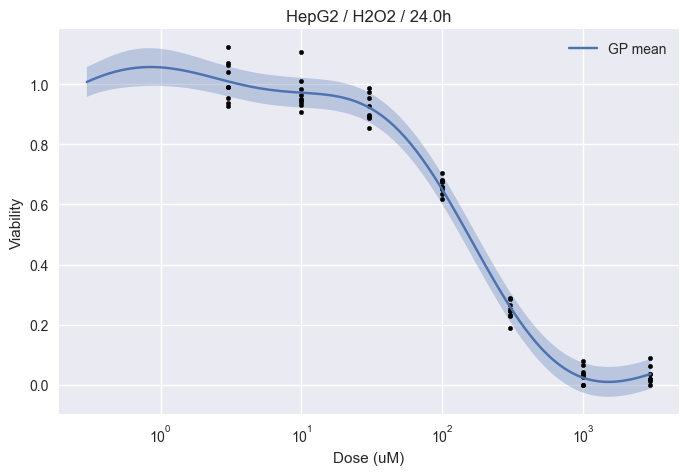

In [32]:
# 5. Plot one slice

def plot_slice(gp, df):
    subset = df[
        (df["cell_line"] == gp.cell_line)
        & (df["compound"] == gp.compound)
        & (df["time_h"] == gp.time_h)
    ]

    grid = gp.predict_on_grid(num_points=100)

    plt.figure(figsize=(8, 5))
    plt.plot(grid["dose_uM"], grid["mean"], label="GP mean")
    plt.fill_between(grid["dose_uM"], 
                     grid["mean"] - grid["std"],
                     grid["mean"] + grid["std"],
                     alpha=0.3)
    plt.scatter(subset["dose_uM"], subset["viability_corrected"], s=10, color="black")
    plt.xscale("log")
    plt.title(f"{gp.cell_line} / {gp.compound} / {gp.time_h}h")
    plt.xlabel("Dose (uM)")
    plt.ylabel("Viability")
    plt.legend()
    plt.show()

example_key = list(gp_models.keys())[0]
plot_slice(gp_models[example_key], df_corr)


Plotting slice: ('HepG2', 'H2O2', 24.0)


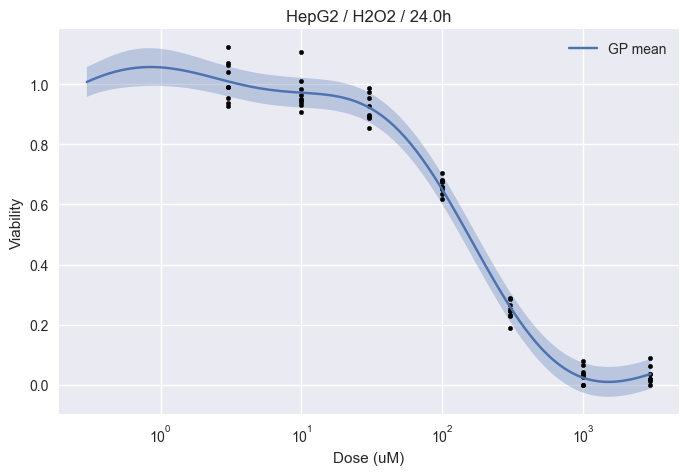

Plotting slice: ('HepG2', 'staurosporine', 24.0)


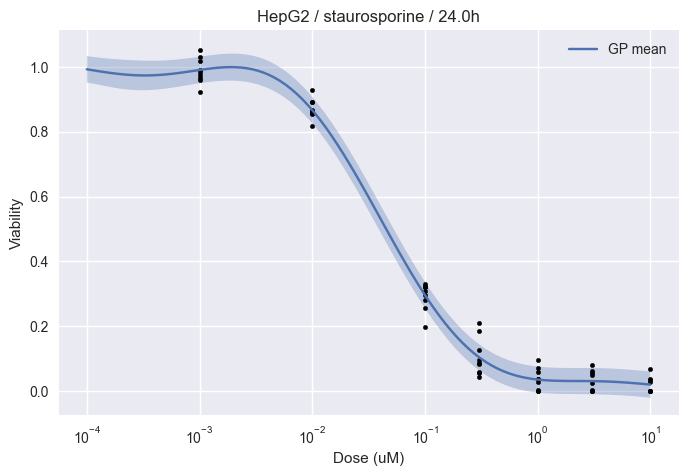

Plotting slice: ('HepG2', 'tunicamycin', 24.0)


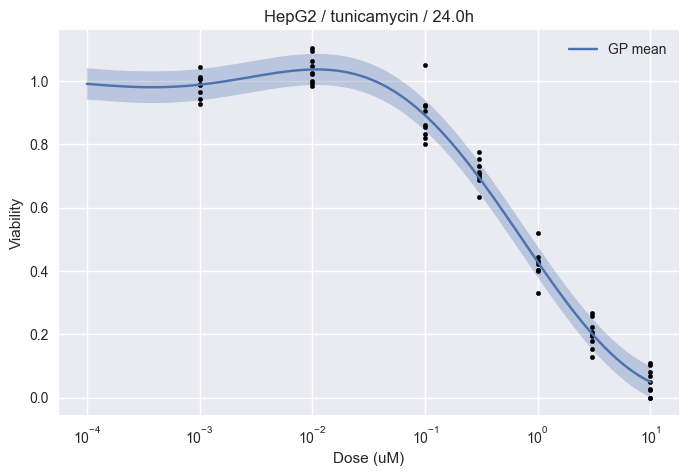

Plotting slice: ('U2OS', 'H2O2', 24.0)


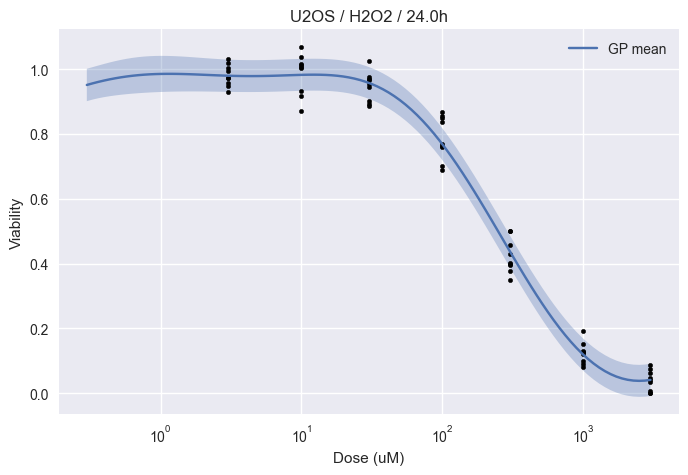

Plotting slice: ('U2OS', 'staurosporine', 24.0)


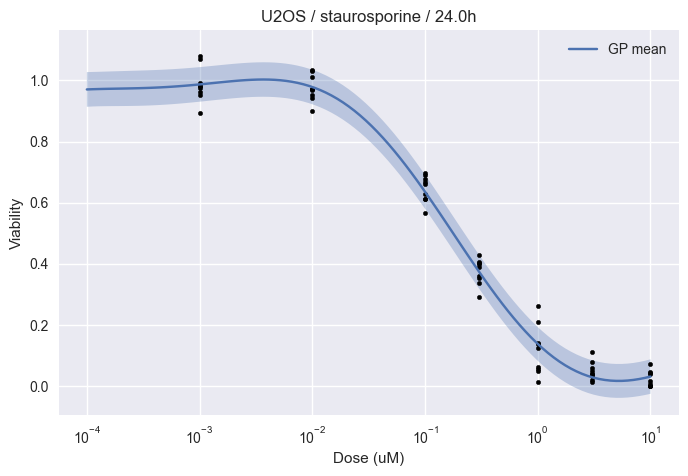

Plotting slice: ('U2OS', 'tunicamycin', 24.0)


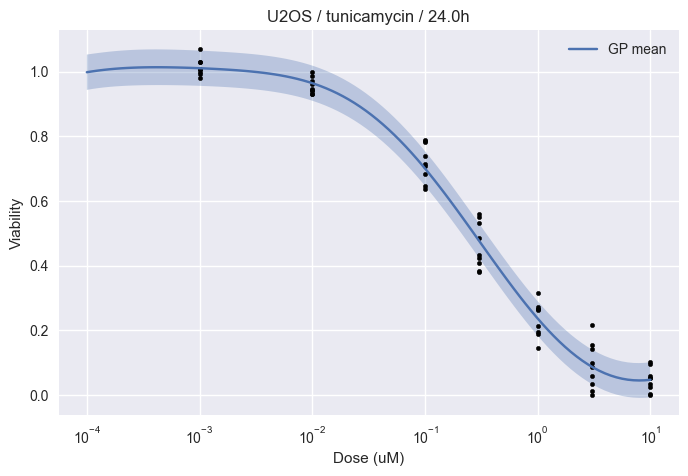

In [34]:
for key, gp in gp_models.items():
    print(f"Plotting slice: {key}")
    plot_slice(gp, df_corr)
